In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

In [2]:
country_code = "US"
start_date='01/01/2010'
end_date='06/01/2020'
print('Country:', country_code)
print('End date:', end_date)

Country: US
End date: 06/01/2020


In [3]:
country_code = "US"
labels=['loss', 'unemployed', 'search', 'hire', 'offer', 'out_of_work']
features=['statuses_count', 'account_age', 'followers_count', 'friends_count']
print('Country:', country_code)
print('\nLabels:\n','\n'.join(labels))
print('\nFeatures:\n','\n'.join(features))

Country: US

Labels:
 loss
unemployed
search
hire
offer
out_of_work

Features:
 statuses_count
account_age
followers_count
friends_count


In [4]:
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='../../data'

In [5]:
print('Load')
start = timer()
users_counts=pq.ParquetDataset(glob(os.path.join(path_to_data,'classification',country_code,'users_counts','*.parquet'))).read().to_pandas()
locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))
labor_stats=pd.read_csv(os.path.join(path_to_data,'official','country','monthly.csv'))
print("Done in", round(timer()-start), "sec")

Load
Done in 5 sec


In [6]:
labor_stats=labor_stats[['date',country_code]].copy()
labor_stats['year']=labor_stats['date'].map(lambda x:pd.to_datetime(x).year)
labor_stats['month']=labor_stats['date'].map(lambda x:pd.to_datetime(x).month)
labor_stats.rename(columns={country_code:'unemployment_rate'},inplace=True)
labor_stats.drop('date',1,inplace=True)
labor_stats['unemployment_rate']/=100

## Split by type of status

In [29]:
print('Prepare dataset')
start = timer()
df=users_counts.merge(locations.loc[locations.country_short==country_code,['user_location']]).drop('user_location',1)
df.year=df.year.astype(int)
df.month=df.month.astype(int)
df=df.groupby(['year','month'],as_index=False)[labels+['user_id']].sum()
df=df.merge(labor_stats,on=['year','month'])
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0) 
df.drop(['year','month'],1,inplace=True)
df=df[(df.date>=pd.to_datetime(start_date))&(df.date<=pd.to_datetime(end_date))].copy()
df['unemployment_lag']=df['unemployment_rate'].shift()
df.dropna(inplace=True)
for label in labels:
    df[label]=df[label].divide(df['user_id'])
print("Done in", round(timer()-start), "sec")

Prepare dataset
Done in 24 sec


/Users/samuelfraiberger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  import sys


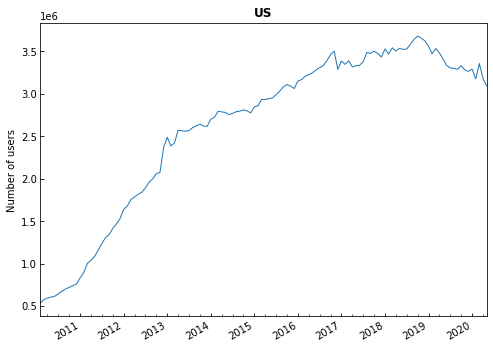

In [25]:
fig,ax=plt.subplots(figsize=(8,6))
df.plot(ax=ax,y='user_id',x='date',style='-',linewidth=1,legend=False)
ax.set_xlabel('')
ax.set_ylabel('Number of users')
ax.set_title(country_code,fontweight='bold')
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='both',nbins=10)
fig.autofmt_xdate()

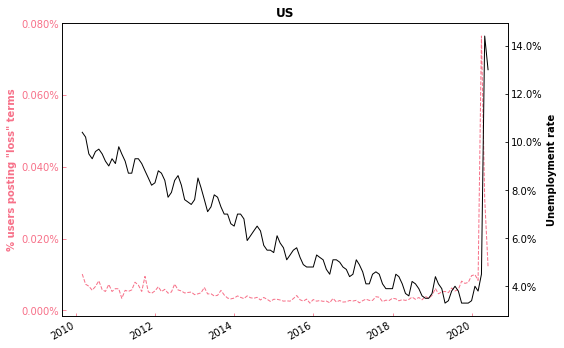

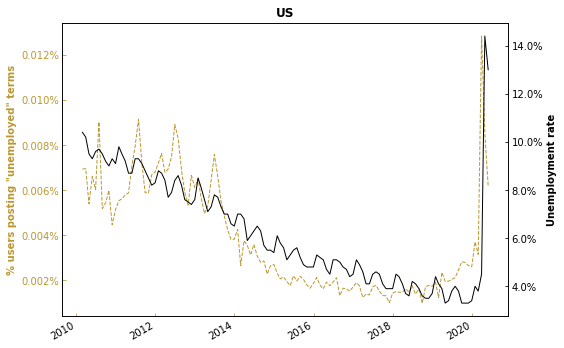

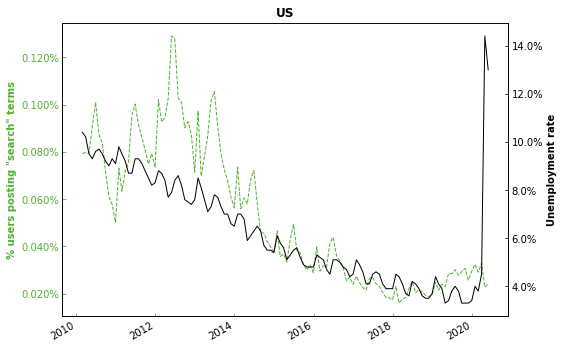

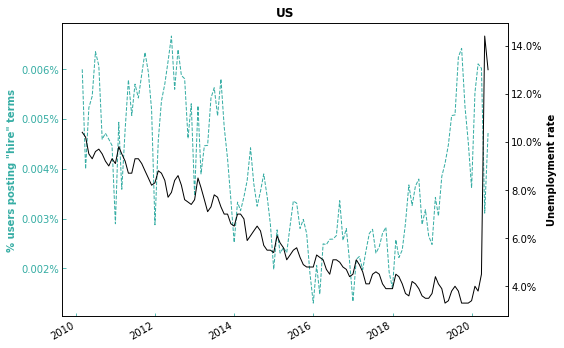

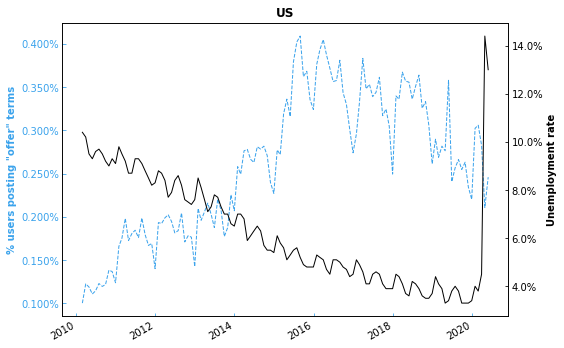

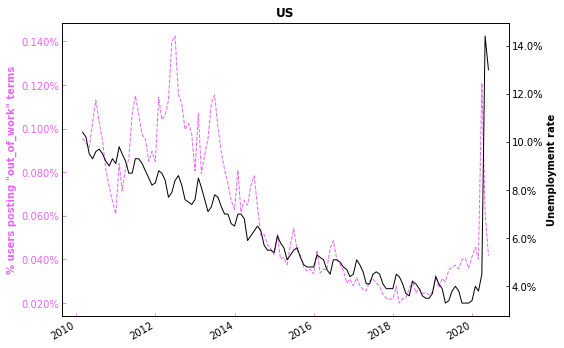

In [26]:
colors = sns.color_palette("husl", 12)
for i,label in enumerate(labels):
    fig,ax1=plt.subplots(figsize=(8,6))
    ax2 = ax1.twinx()
    ax1.plot(df['date'],df[label],linewidth=1,color=colors[2*i],linestyle='dashed')
    ax2.plot(df['date'],df['unemployment_rate'],linewidth=1,color='k')
    ax1.tick_params(which='both',direction='in',pad=3,color=colors[2*i])
    ax2.tick_params(which='both',direction='in',pad=3,color='k')
    ax1.locator_params(axis='y',nbins=8)
    ax2.locator_params(axis='y',nbins=8)
    ax1.set_xlabel('')
    ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
    ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
    ax1.set_ylabel('% users posting "'+label+'" terms',fontweight='bold',color=colors[2*i])
    ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
    ax1.set_title(country_code,fontweight='bold')
    fig.autofmt_xdate()
    plt.savefig(os.path.join(path_to_data,'../fig/','aggregates',country_code+label+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')

In [27]:
exogs=[['unemployment_lag']]
for label in sorted(labels):
    exogs.extend([[label],['unemployment_lag',label]])
models=[]
for exog in exogs:
    models.append(sm.OLS(endog=df['unemployment_rate'],exog=sm.add_constant(df[exog])).fit())
stargazer = Stargazer(models)
stargazer.dependent_variable_name('Unemployment rate')
HTML(stargazer.render_html())

In [30]:
date_split='1/1/2017'
exogs=[['unemployment_lag']]
exogs.append(['loss', 'unemployed', 'search', 'out_of_work']+['unemployment_lag'])

rmse=[]
y_predict={}
for (name,exog) in zip(['AR(1)','AR(1)+Twitter'], exogs):
    train=df[df['date']<=pd.to_datetime(date_split)].copy()
    test=df[df['date']>pd.to_datetime(date_split)].copy()
    model=sm.OLS(endog=train['unemployment_rate'],exog=sm.add_constant(train[exog])).fit()
    y_predict[name]=sm.add_constant(test[exog]).multiply(model.params).sum(1)
    rmse.append((name,np.sqrt(np.mean((test['unemployment_rate']-y_predict[name])**2))))

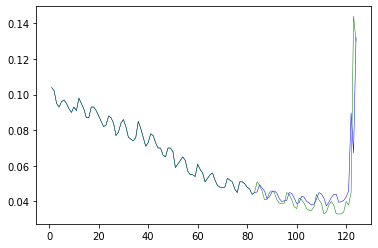

In [48]:
# add lag terms
# pd.concat([train['unemployment_rate'],y_predict['AR(1)']]).plot(linewidth=0.5,color='r')
pd.concat([train['unemployment_rate'],y_predict['AR(1)+Twitter']]).plot(linewidth=0.5,color='b')
df['unemployment_rate'].plot(linewidth=0.5,color='g')

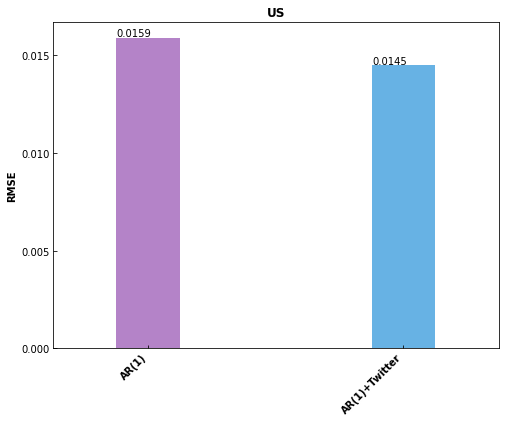

In [49]:
fig,ax=plt.subplots(figsize=(8,6))
pd.DataFrame(rmse,columns=['model','RMSE']).set_index('model')['RMSE'].plot(
ax=ax,
kind='bar',
width=.25,    
legend=False, 
stacked=True, 
color=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
alpha=0.75)
ax.set_xlabel('')
ax.set_ylabel('RMSE',fontweight='bold',color='k')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right',fontweight='bold')
ax.locator_params(axis='y',nbins=5)
ax.set_title(country_code,fontweight='bold')
for p in ax.patches:
    ax.annotate("{:.4f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Split by user's type

In [12]:
print('Prepare dataset')
start = timer()
df=users_counts.merge(locations.loc[locations.country_short==country_code,['user_location']]).drop('user_location',1)
df.year=df.year.astype(int)
df.month=df.month.astype(int)
df=df.groupby(['year','month','statuses_count_quantile'],as_index=False)[labels+['user_id']].sum()
for label in labels:
    df[label]=df[label].divide(df['user_id'])
df.set_index(['year','month','statuses_count_quantile'],inplace=True)
df=df['out_of_work'].unstack(level='statuses_count_quantile')
df.columns=['Low-activity users','High-activity users']
df=df.reset_index().merge(labor_stats,on=['year','month'])
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0) 
df.drop(['year','month'],1,inplace=True)
df['unemployment_lag']=df['unemployment_rate'].shift()
df.dropna(inplace=True)
df=df[(df.date>=pd.to_datetime(start_date))&(df.date<=pd.to_datetime(end_date))].copy()
print("Done in", round(timer()-start), "sec")

Prepare dataset
Done in 18 sec


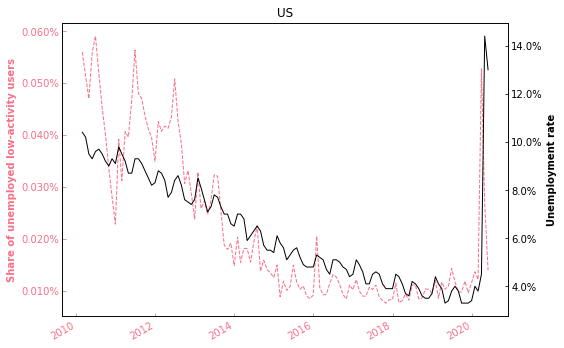

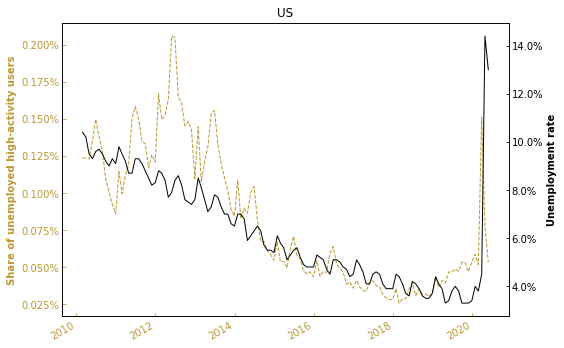

In [13]:
colors = sns.color_palette("husl", 12)
for i,feature in enumerate(['Low-activity users','High-activity users']):
    fig,ax1=plt.subplots(figsize=(8,6))
    ax2 = ax1.twinx()
    ax1.plot(df['date'],df[feature],linewidth=1,color=colors[2*i],linestyle='dashed')
    ax2.plot(df['date'],df['unemployment_rate'],linewidth=1,color='k')
    ax1.tick_params(which='both',direction='in',pad=3,colors=colors[2*i])
    ax2.tick_params(which='both',direction='in',pad=3,colors='k')
    ax1.locator_params(axis='y',nbins=8)
    ax2.locator_params(axis='y',nbins=8)
    ax1.set_xlabel('')
    ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
    ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
    ax1.set_ylabel('Share of unemployed '+feature.lower(),fontweight='bold',color=colors[2*i])
    ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
    ax1.set_title(country_code)
    fig.autofmt_xdate()
    plt.savefig(os.path.join(path_to_data,'../fig/','aggregates',country_code+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')

In [14]:
exogs=[['unemployment_lag']]
for label in ['High-activity users', 'Low-activity users']:
    exogs.extend([[label],['unemployment_lag',label]])
exogs.extend([['High-activity users', 'Low-activity users']])
exogs.extend([['unemployment_lag','High-activity users', 'Low-activity users']])
models=[]
for exog in exogs:
    models.append(sm.OLS(endog=df['unemployment_rate'],exog=sm.add_constant(df[exog])).fit())
stargazer = Stargazer(models)
stargazer.dependent_variable_name('unemployment rate')
HTML(stargazer.render_html())

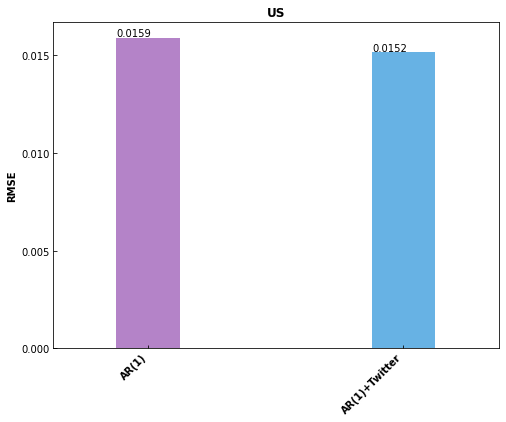

In [22]:
date_split='1/1/2017'
exogs=[['unemployment_lag']]
exogs.append(['Low-activity users', 'High-activity users']+['unemployment_lag'])

rmse=[]
for (name,exog) in zip(['AR(1)','AR(1)+Twitter'], exogs):
    train=df[df['date']<=pd.to_datetime(date_split)].copy()
    test=df[df['date']>pd.to_datetime(date_split)].copy()
    model=sm.OLS(endog=train['unemployment_rate'],exog=sm.add_constant(train[exog])).fit()
    y_predict=sm.add_constant(test[exog]).multiply(model.params).sum(1)
    rmse.append((name,np.sqrt(np.mean((test['unemployment_rate']-y_predict)**2))))
    
fig,ax=plt.subplots(figsize=(8,6))
pd.DataFrame(rmse,columns=['model','RMSE']).set_index('model')['RMSE'].plot(
ax=ax,
kind='bar',
width=.25,    
legend=False, 
stacked=True, 
color=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
alpha=0.75)
ax.set_xlabel('')
ax.set_ylabel('RMSE',fontweight='bold',color='k')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right',fontweight='bold')
ax.locator_params(axis='y',nbins=5)
ax.set_title(country_code,fontweight='bold')
for p in ax.patches:
    ax.annotate("{:.4f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))